In [44]:
def find_mismatches(seq1, seq2):
    mismatches = []
    for i, (nucleotide1, nucleotide2) in enumerate(zip(seq1, seq2)):
        if nucleotide1 != nucleotide2 and '-' not in (nucleotide1, nucleotide2):
            mismatches.append((i,nucleotide1, nucleotide2))
    return mismatches
def count_mutations(base_pairs):
    mutation_count = {}
    mutation_in_count ={}
    mutation_out_count = {}
    for base_pair in base_pairs:
        pos,original_base, mutated_base = base_pair
        if original_base != mutated_base:
            mutation = f"{original_base}->{mutated_base}"
            if mutation in mutation_count:
                mutation_count[mutation] += 1
            else:
                mutation_count[mutation] = 1

    return mutation_count

def add_dicts(dict1, dict2):
    result_dict = dict(dict1)  # Create a new dictionary with the values from dict1

    for key, value in dict2.items():
        if key in result_dict:
            result_dict[key] += value  # Add the value to the existing key in result_dict
        else:
            result_dict[key] = value  # Add the new key-value pair to result_dict

    return result_dict
def combine_insertions(insertions):
    """
    This function takes in a list of insertion information as tuples, where the first value in each tuple is the position
    and the second value is the DNA base. It combines adjacent insertions at the same position and returns a new list of tuples,
    where the first value is the position of the insertion and the second value is a string representing the combined bases.
    """
    combined = []
    current_pos = None
    current_bases = ''
    for pos, base in insertions:
        if current_pos is None:
            current_pos = pos
            current_bases = base
        elif pos == current_pos + len(current_bases):
            current_bases += base
        else:
            combined.append((current_pos, current_bases))
            current_pos = pos
            current_bases = base
    combined.append((current_pos, current_bases))
    return combined

def insertion_deletion_position(alignment_len,insertion,deletion):
    insertion_fixed = []
    deletion_fixed = []
    fix_index = 0
    for num in range(alignment_len):
        if len(insertion) >=1:
            if insertion[0][0] == num:
                insertion_fixed.append((insertion[0][0]+fix_index, insertion[0][1]))
                fix_index -= len(insertion[0][1])
                
                insertion = insertion[1:]
                
            
        if len(deletion) >=1:    
            if deletion[0][0] == num:
                deletion_fixed.append((deletion[0][0]+fix_index,deletion[0][1]))
                deletion = deletion[1:]
            
        else:
            pass
    return insertion_fixed, deletion_fixed
        
    

def main(ref_seq,query_seq):
    # remove gaps at the start or end of the sequences
    alignment_len = len(ref_seq)
    removed = 0
    while ref_seq.startswith("-"):

        ref_seq = ref_seq[1:]
        query_seq = query_seq[1:]
        
    while query_seq.startswith("-"):
        removed = removed + 1
        ref_seq = ref_seq[1:]
        query_seq = query_seq[1:]        
    while ref_seq.endswith("-") or query_seq.endswith("-"):
        ref_seq = ref_seq[:-1]
        query_seq = query_seq[:-1]
    # initialize variables for tracking insertion, deletion, and mismatch counts
    insertion_count = 0
    deletion_count = 0
    mismatch_count = 0
    insertion = []
    deletion = []
    mismatch = []
    # iterate over each position in the sequences
    
    for i in range(len(ref_seq)):
        if ref_seq[i] == query_seq[i]:
            # the bases match, do nothing
            pass
        elif query_seq[i] == "-":
            # this is a deletion in the query sequence
            
            deletion_tuple = (i+removed+1,ref_seq[i])
            deletion.append(deletion_tuple)
            deletion_count += 1
        elif ref_seq[i] == "-":
            # this is an insertion in the query sequence
            
            insertion_tuple = (i+removed+1,query_seq[i])
            insertion.append(insertion_tuple)
            insertion_count += 1
        else:
            # this is a substitution
            mismatch_count += 1
            mismatch_tuple = (i+removed-insertion_count+1,ref_seq[i],query_seq[i])
            
            mismatch.append(mismatch_tuple)
    #print(insertion)
    insertion = combine_insertions(insertion)
    deletion = combine_insertions(deletion)
    insertion_fix, deletion_fix = insertion_deletion_position(alignment_len,insertion,deletion)
    return deletion_fix, insertion_fix,mismatch
from Bio import pairwise2
from Bio.Seq import Seq
def aligned(ref_seq,query_seq):
    # Define the gap penalty

    ref_seq = Seq(ref_seq.upper())
    query_seq = Seq(query_seq.upper())
    # Perform global sequence alignment with custom gap penalty
    # 0.5 points are deducted when opening a gap, and 0.1 points are
    alignments = pairwise2.align.globalms(ref_seq, query_seq, 3, -1, -5, -0.1)
    #print(alignments)
    query_aligned = alignments[0][1]
    ref_aligned = alignments[0][0]
    return query_aligned, ref_aligned



def short_DNA_align(seq1,seq2):
    # Define the scoring parameters
    match_score = 1
    mismatch_penalty = -1
    gap_open_penalty = -2
    gap_extension_penalty = -1

    # Perform the pairwise alignment using globalds function
    alignments = pairwise2.align.globalms(seq1, seq2, match_score, mismatch_penalty, gap_open_penalty, gap_extension_penalty)

    # Extract the first (and only) alignment from the list of alignments
    alignment = alignments[0]

    # Calculate the number of gaps and mismatches in the alignment
    num_gaps = alignment[0].count("-")+alignment[1].count("-")
    num_mismatches = sum(1 for a, b in zip(*alignment[:2]) if a != b and a != "-" and b != "-")

    # Calculate the total number of gaps and mismatches
    total_errors = num_gaps + num_mismatches

    # Print the alignment and the total number of gaps and mismatches
    return total_errors
def get_expect(df,expect_seq):
    no_gaps_ref = df['Reference_Sequence'][0].replace("-", "")
    expext_aligned, ref_aligned = aligned(no_gaps_ref,expect_seq)
    #print( expext_aligned, ref_aligned )
    deletion, insertion,mismatch = main(ref_aligned,expext_aligned)
    return deletion, insertion,mismatch
def dict_change (dict_,name, value):
    if name not in dict_:
        dict_[name]= value
    else:
        dict_[name] += value
    return dict_
def insertion_check (insertion ,insertion_exp ,mismath_gap_allow):
    for tup in insertion:
        error_ins = short_DNA_align(tup[1],insertion_exp[0][1])
        if error_ins < mismath_gap_allow:
            return True
            break
    return False

def read_fasta(file_path):
    sequences = {}
    with open(file_path, 'r') as fasta_file:
        sequence_id = None
        sequence = ''
        for line in fasta_file:
            line = line.strip()
            if line.startswith('>'):
                if sequence_id:
                    sequences[sequence_id] = sequence
                sequence_id = line[1:]
                sequence = ''
            else:
                sequence += line
        if sequence_id:
            sequences[sequence_id] = sequence
    return sequences

In [45]:
import matplotlib.pyplot as plt
def classify_data(df_alleles,Locus,exp_dict):
    dict_classified = {'unmodified': 0,'deletion_only': 0,'unrelated_insertion': 0,'perfect_editing': 0, 'mismatch_only': 0,
         'perfect_insertion_with_mismatch': 0, 'deletion_and_mismatch': 0,'imperfect_insertion': 0,
          'perfect_insertion_with_deletion': 0,'perfect_insertion_with_deletion_and_mismatch':0}
    deletion_exp, insertion_exp,mismatch_exp =exp_dict[Locus]
    for num in range(len(df_alleles)):
    #for num in range(10):
        deletion, insertion, mismatch = main(df_alleles['Reference_Sequence'][num],df_alleles['Aligned_Sequence'][num])
        if deletion == [] and insertion == [] and mismatch == []:
            dict_classified = dict_change(dict_classified,'unmodified', df_alleles['%Reads'][num])

        elif len(insertion) != 0:
            #print(insertion)
            if insertion == insertion_exp:
                if deletion == deletion_exp and mismatch == mismatch_exp:
                    dict_classified = dict_change(dict_classified,'perfect_editing', df_alleles['%Reads'][num])
                elif deletion == deletion_exp:
                    dict_classified = dict_change(dict_classified,'perfect_insertion_with_mismatch', df_alleles['%Reads'][num])
                elif mismatch == mismatch_exp:
                    dict_classified = dict_change(dict_classified,'perfect_insertion_with_deletion', df_alleles['%Reads'][num])
                else:
                    dict_classified = dict_change(dict_classified,'perfect_insertion_with_deletion_and_mismatch', df_alleles['%Reads'][num])
            elif all(tup in insertion_exp for tup in insertion):
                dict_classified = dict_change(dict_classified,'perfect_insertion_with_insertion', df_alleles['%Reads'][num])
            else:
                if insertion_check(insertion ,insertion_exp ,mismath_gap_allow) == True:
                    dict_classified = dict_change(dict_classified,'imperfect_insertion', df_alleles['%Reads'][num])
                else:    
                    dict_classified = dict_change(dict_classified,'unrelated_insertion', df_alleles['%Reads'][num])
        elif len(deletion) != 0:
            if len(mismatch) == 0:
                dict_classified = dict_change(dict_classified,'deletion_only', df_alleles['%Reads'][num])
            else:
                dict_classified = dict_change(dict_classified,'deletion_and_mismatch', df_alleles['%Reads'][num])
        else:
            dict_classified = dict_change(dict_classified,'mismatch_only', df_alleles['%Reads'][num])


            pass
    # Define the data as a dictionary
    

    # Define the labels and values for the pie chart
    labels = list(dict_classified.keys())
    values = list(dict_classified.values())
    return dict_classified



In [46]:
def nt_count(df_alleles,site):
    ref_ins = exp_dict[site][1]
    mutation_count = {}
    mutation_in_count ={}
    mutation_out_count = {}
    for num in range(len(df_alleles)):
        deletion, insertion, mismatch = main(df_alleles['Reference_Sequence'][num],df_alleles['Aligned_Sequence'][num])
        if len(insertion) != 0:
            if insertion_check(insertion ,ref_ins,mismath_gap_allow) != False:            
                for base_pair in mismatch:
                    pos,original_base, mutated_base = base_pair
                    mutation = f"{original_base}->{mutated_base}"
                    if mutation in mutation_out_count:
                        mutation_out_count[mutation] += df_alleles['#Reads'][num]
                    else:
                        mutation_out_count[mutation]= df_alleles['#Reads'][num]

                seq1 ,seq2 = aligned(insertion[0][1], ref_ins[0][1])
                mismatches_2 = find_mismatches( seq1 ,seq2 )
                #print(mismatches_2)
                for base_pair2 in mismatches_2:
                    pos,original_base, mutated_base = base_pair2
                    mutation = f"{original_base}->{mutated_base}"                
                    if mutation in mutation_in_count:
                        mutation_in_count[mutation] += df_alleles['#Reads'][num]
                    else:
                        mutation_in_count[mutation]= df_alleles['#Reads'][num]
            else:
                pass
        else:
            pass
    return mutation_in_count ,mutation_out_count


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
def plot_mutation_heatmap(mutation_counts,sum_):
    # Create a 4x4 matrix to store the mutation rates
    mutation_rates = np.zeros((4, 4))

    # Iterate over the mutation counts dictionary
    
    for mutation, count in mutation_counts.items():
        if "->" in mutation and 'N' not in mutation:
            # Extract the mutation types
            mutation_from = mutation[0]
            mutation_to = mutation[3]

            # Get the indices for the mutation types
            col = "ATCG".index(mutation_from)
            row = "ATCG".index(mutation_to)
            #print(row)
            # Calculate the mutation rate by dividing the count by the total reads
            mutation_rates[row, col] = count / sum_
    print(mutation_rates)
    # Define the x-axis and y-axis labels
    labels = ["A", "T", "C", "G"]

    # Create the heatmap
    fig, ax = plt.subplots()
    norm = mcolors.LogNorm(vmin=np.min(1e-6), vmax=np.max(1e-4))  # Set the logarithmic normalization
    im = ax.imshow(mutation_rates, cmap="plasma",norm=norm)

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set the colorbar label
    cbar.ax.set_ylabel("Mutation Rate", rotation=-90, va="bottom")

    # Set the tick labels for x-axis and y-axis
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Set the tick labels for x-axis and y-axis to be centered
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, "{:.2e}".format(mutation_rates[i, j]), ha="center", va="center", color="black")

    # Set the title
    ax.set_title("Mutation rate inside of insertion NRT-49")
    plt.xlabel("To",fontsize=12)
    plt.ylabel("From",fontsize=12)
    # Show the plot
    plt.show()


#plot_mutation_heatmap(dict_in,total_N)


In [71]:
#ngs_num = 9
def get_nt_substitution (ngs_id,df_Locus,path_name):

    if len(df_Locus.loc[df_Locus['NGS_id'] == ngs_id, 'Locus']) == 0:
        print('bug')
    else:
        Locus = df_Locus.loc[df_Locus['NGS_id'] == ngs_id, 'Locus'].values[0].replace(" ", "")
        df_alleles =  pd.read_csv(path_name,sep='\t')
        mutation_ins_count ,mutation_arm_count = nt_count(df_alleles,Locus)
        dict_  = classify_data(df_alleles,Locus.replace(" ", ""),exp_dict)
        N_perent = dict_['perfect_editing']+dict_['perfect_insertion_with_mismatch']+dict_['perfect_insertion_with_deletion']+dict_['imperfect_insertion']+dict_['perfect_insertion_with_deletion_and_mismatch']
        N =df_alleles['#Reads'].sum() *N_perent
    return N,mutation_ins_count ,mutation_arm_count

In [72]:
mismath_gap_allow = 3
df_Locus = pd.read_csv('example.csv')
exp_dict = {'HBB':[[],[(87, 'AGCATGTAGC')],[]] ,'F9':[[],[(119, 'GCATGTAGCA')] ,[]],'EMX1':[[],[(121, 'AGCATGTAGC')],[]],'CFTR':[[], [(119, 'AGCATGTAGC')],[]]}
ngs_id = '637-1'
path_name = './data/637-1.txt'

In [73]:
N,mutation_ins_count ,mutation_arm_count = get_nt_substitution (ngs_id,df_Locus,path_name)

[[0.00000000e+00 2.23968423e-05 2.56695912e-05 2.60773074e-05]
 [5.79618157e-06 0.00000000e+00 8.43531748e-06 1.39615248e-05]
 [1.63747639e-05 7.03585919e-06 0.00000000e+00 2.17742486e-05]
 [1.30965053e-05 1.07879501e-05 4.97523951e-06 0.00000000e+00]]


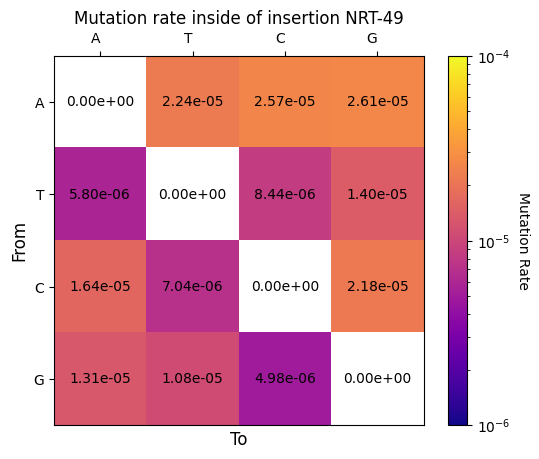

In [74]:
plot_mutation_heatmap(mutation_ins_count,N)

[[0.00000000e+00 9.39400150e-05 3.54399037e-04 1.50155263e-04]
 [2.05808523e-04 0.00000000e+00 1.19411258e-04 4.48333543e-04]
 [7.02979854e-04 8.95157434e-05 0.00000000e+00 1.42039507e-04]
 [2.03676278e-04 5.81750403e-04 1.04838159e-04 0.00000000e+00]]


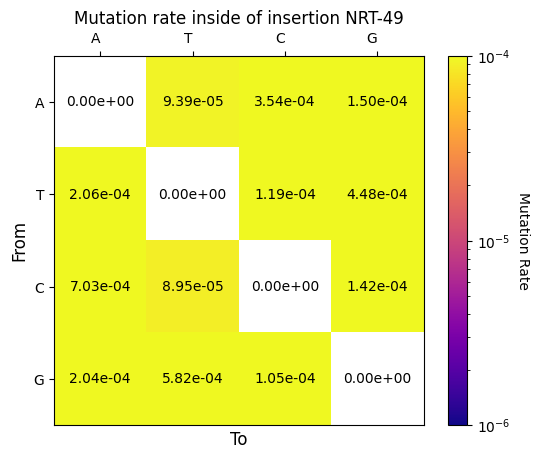

In [75]:
plot_mutation_heatmap(mutation_arm_count,N)